# Baseline model:
This notebook contains our baseline model without feature engineering. We will test out  3 different classification models on our data set to see which performs best. We will then perform feature selection and hyperparameter tuning.

## Needed libraries:

In [198]:
%load_ext lab_black
%matplotlib inline

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [221]:
# data frame and visualization libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lantern as lt
import warnings
from sklearn.tree import export_graphviz

# validation and split libraries
from sklearn.model_selection import train_test_split

#

# Statistical model libraries
from sklearn.tree import DecisionTreeClassifier

### Functions we will use

In [200]:
from sklearn.metrics import roc_auc_score


def scores(model, X_train, X_val, y_train, y_val):
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    train = roc_auc_score(y_train, train_prob)
    val = roc_auc_score(y_val, val_prob)
    print("train:", round(train, 2), "test:", round(val, 2))

In [201]:
def annot(fpr, tpr, thr):
    k = 0
    for i, j in zip(fpr, tpr):
        if k % 50 == 0:
            plt.annotate(round(thr[k], 2), xy=(i, j), textcoords="data")
        k += 1

In [202]:
from sklearn.metrics import roc_curve


def roc_plot(model, X_train, y_train, X_val, y_val):
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    plt.figure(figsize=(7, 7))
    for data in [[y_train, train_prob], [y_val, val_prob]]:  # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.ylabel("TPR (power)")
    plt.xlabel("FPR (alpha)")
    plt.legend(["train", "val"])
    plt.show()

In [203]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [
        col
        for col in opt.columns
        if ("mean" in col or "std" in col) and "time" not in col
    ]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params, opt[cols]], axis=1, sort=False)

    plt.figure(figsize=[15, 4])
    plt.subplot(121)
    sns.heatmap(
        pd.pivot_table(
            opt,
            index="max_depth",
            columns="min_samples_leaf",
            values="mean_train_score",
        )
        * 100
    )
    plt.title("ROC_AUC - Training")
    plt.subplot(122)
    sns.heatmap(
        pd.pivot_table(
            opt, index="max_depth", columns="min_samples_leaf", values="mean_test_score"
        )
        * 100
    )
    plt.title("ROC_AUC - Validation")


#     return opt

## Load the Data:

In [204]:
baseline_df = pd.read_csv("../data/telecom_cleaned.csv")

In [205]:
print("-----------------------------------------")
print("The Dataframe has:", baseline_df.shape[1], "columns")
print("The Dataframe has:", baseline_df.shape[0], "rows")
print("-----------------------------------------")

-----------------------------------------
The Dataframe has: 22 columns
The Dataframe has: 3333 rows
-----------------------------------------


In [206]:
list(baseline_df.columns)

['Unnamed: 0',
 'state',
 'account_length',
 'area_code',
 'phone_number',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'churn']

## Create Train/Test/Split and Validation sets

In [207]:
X = baseline_df.drop(
    [
        "Unnamed: 0",
        "churn",
        "state",
        "phone_number",
        "international_plan",
        "voice_mail_plan",
    ],
    axis=1,
)
y = baseline_df.loc[:, ["churn"]]

In [208]:
# Visualize our classes
class_0 = y.query("churn==False")
class_1 = y.query("churn==True")

# plt.figure()
# plt.scatter(class_0[:,0], class_0[:,1], color='black', marker='s')
# plt.scatter(class_1[:,0], class_1[:,1], color='black', marker='x')
# plt.show()

In [209]:
# Create our train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Create our validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1
)

In [210]:
print("------------------------------------------------")
print("The X and Y Train shape is:", X_train.shape, y_train.shape)
print("The X and Y Val shape is:", X_val.shape, y_val.shape)
print("The X and Y Test shape is:", X_test.shape, y_test.shape)
print("Totals :", X_train.shape[0] + X_val.shape[0] + X_test.shape[0], "Rows")
print("------------------------------------------------")

------------------------------------------------
The X and Y Train shape is: (2132, 16) (2132, 1)
The X and Y Val shape is: (534, 16) (534, 1)
The X and Y Test shape is: (667, 16) (667, 1)
Totals : 3333 Rows
------------------------------------------------


In [211]:
baseline_df["churn"].value_counts()

False    2850
True      483
Name: churn, dtype: int64

## Logistic regression

In [212]:
from sklearn.linear_model import LogisticRegression

In [213]:
model = LogisticRegression(random_state=1)

## Naive Bayes

In [214]:
from sklearn.naive_bayes import GaussianNB

In [215]:
model = GaussianNB()

## Decision tree

In [216]:
from sklearn.tree import DecisionTreeClassifier

In [256]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=140)

In [257]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=140, splitter='best')

In [258]:
from sklearn.metrics import roc_curve, roc_auc_score

train: 0.74 test: 0.71


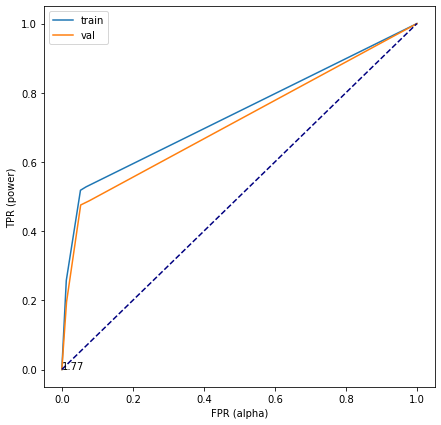

In [259]:
scores(tree_clf, X_train, X_val, y_train, y_val)
roc_plot(tree_clf, X_train, y_train, X_val, y_val)

Totally not suspicious at all 

In [260]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [261]:
dot_data = StringIO()

In [262]:
export_graphviz(
    model,
    out_file=dot_data,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

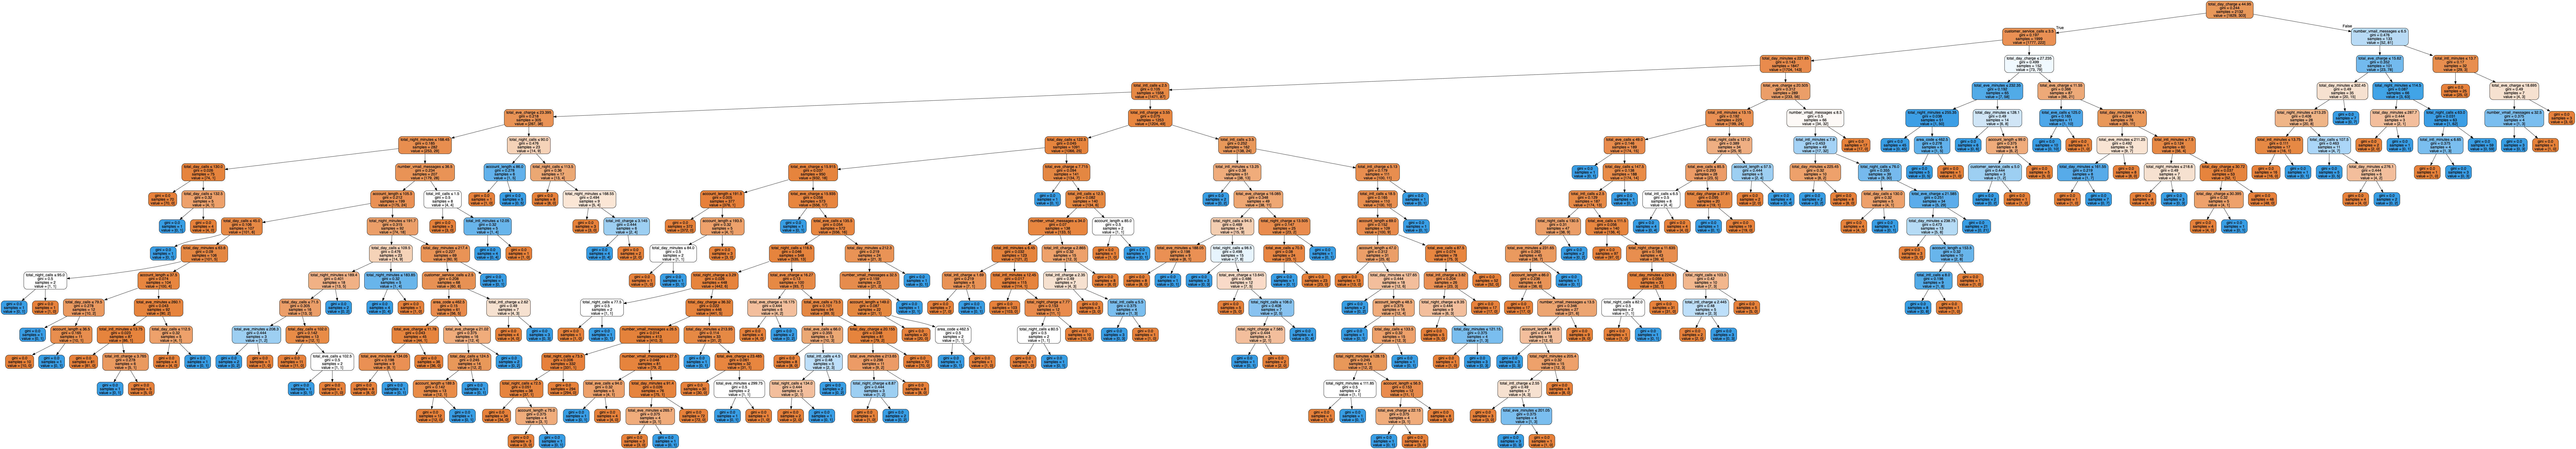

In [263]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())